**Abstract**

The rapid advances in generative AI have the potential to reshape organizational innovation, raising uncertainty about the role of human solvers in this new era of augmented intelligence. We initiated a crowdsourcing challenge focused on sustainable, circular economy business opportunities, comparing the capabilities of GPT-4 and human solvers in generating novel and valuable solutions. The challenge attracted a diverse range of global solvers from various industries. 300 evaluators assessed a randomized selection of 13 out of 234 human and AI solutions, totaling 3,900 evaluator–solution pairs. Our findings reveal that, although AI solutions delivered more environmental and financial value—possibly due to a tendency to align with the central patterns seen in their training—human outputs were rated as more innovative, including extreme outcomes at the right tail of the novelty distribution. Our analysis of the rich solution text using natural language processing techniques reveals considerable overlap in semantic dissimilarity metrics between human and AI responses, but humans still exhibit greater linguistic nuances than AI. This study illuminates the promise of AI in augmenting human crowdsourcing for solving complex organizational problems and sets the groundwork for a possible integrative human-AI approach to innovative problem-solving.

Keywords: Generative AI, ChatGPT, LLMs, innovation, crowdsourcing, idea generation, evaluation, novelty, value

[Paper link](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4533642)

The code below is the code used to generate the problem-solution pairs of the 3 levels, with multiple and single instance.


In our study, we explore the use of GPT-4 for generating diverse solutions to challenges in developing sustainable, circular economy business ideas. The effectiveness of GPT-4's output is significantly influenced by the art of prompt engineering, which entails crafting efficient prompts to elicit high-quality, relevant responses from the AI (Brown et al. 2020, Ray 2023). To investigate this, we employed three different prompt engineering strategies to generate AI solutions, details of which are provided in Appendix A.

Recent research indicates that Large Language Models (LLMs) like GPT-4 might produce homogenized outputs, which could limit the diversity of generated ideas. To counter this issue, we experimented with two configurations of GPT-4 designed to enhance output diversity: multiple-instance solutions and single-instance solutions with differentiation instructions.

The first configuration involves deploying separate instances of GPT-4, each generating a solution independently based on the same prompt. Despite identical model and prompt use, the inherent sampling methods of LLMs ensure varied responses from each instance, as the model generates words based on a range of probable next words instead of selecting the single most likely next word.

The second configuration entails a single GPT-4 instance generating multiple solutions sequentially, each differentiated from the last by explicit instructions to vary the output. This approach aims to deepen the exploration of potential solutions by encouraging the model to propose distinct ideas successively. The first configuration simulates the process of independent crowd solvers with each GPT-4 instance acting independently, possibly exploring different facets of the problem and solution space. In contrast, the second configuration resembles an iterative process by an individual solver proposing unique ideas in succession.

For both configurations, we maintained the temperature parameter at the default setting provided by the GPT-4 API (temperature = 1) which determines the randomness of the model's predictions.

# Set up

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [ ]:
import openai
from openai import OpenAI

from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

Enter your OpenAI key here.

In [ ]:
client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="YOUR KEY",
)

## Execute

In [ ]:
adjectives_sol = ["highly detailed and elaborate", "succinct", "brief", "concise", "short", "comprehensive", "long", "5-paragraph", "3-paragraph", "medium-length"]

adjectives_prob = ["highly detailed and elaborate", "succinct", "brief", "concise", "short", "comprehensive", "long", "5-paragraph", "3-paragraph", "medium-length", "very precise and elaborate", "20-sentence"]

k = 125

random.seed(42)  # For reproducibility, if needed

adjectives_solution = random.choices(adjectives_sol, k=k)
adjectives_problem = random.choices(adjectives_prob, k=k)

In [ ]:
# Import necessary libraries
import re
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

import os
import datetime

Mounted at /content/gdrive


### Utils functions:

In [ ]:
def make_distribution_length_plot(entries):
    """
    Creates a histogram of the distribution of problem and solution text lengths.

    Args:
        entries (pd.Series): A pandas Series containing problem-solution pairs.
            Each entry should be a string formatted as "Problem: <problem text>
            Solution: <solution text>".

    Raises:
        ValueError: If the input data is not a pandas Series.
        KeyError: If the 'Problem:' or 'Solution:' keys are not found in the data.
    """

    if not isinstance(entries, pd.Series):
        raise ValueError("Input data must be a pandas Series.")

    # Extract problem and solution texts using regular expressions
    try:
        problem_texts = entries.str.extract(r"Problem: (.*?)Solution:", expand=False, flags=re.DOTALL)
        solution_texts = entries.str.extract(r"Solution: (.*)", expand=False, flags=re.DOTALL)
    except KeyError as e:
        raise KeyError(f"Missing key(s): {e}") from e

    # Handle multi-line texts by replacing newlines with spaces
    problem_texts = problem_texts.str.replace("\n", " ")
    solution_texts = solution_texts.str.replace("\n", " ")

    # Calculate text lengths
    problem_lengths = problem_texts.str.len()
    solution_lengths = solution_texts.str.len()

    # Create the histogram plot
    plt.figure(figsize=(10, 6))
    plt.hist(problem_lengths, bins=10, alpha=0.5, label="Problems")
    plt.hist(solution_lengths, bins=10, alpha=0.5, label="Solutions")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Histogram of Problem and Solution Lengths")
    plt.legend()

    # Ensure plot is shown even in production environments
    plt.show()

In [ ]:
def create_df_answers(entries, p_list, s_list, persona, level_name):
    """
    Creates a DataFrame from problem-solution pairs, adds metadata, saves it
    to Google Drive, and optionally downloads it locally.

    Args:
        entries (pd.Series): A Series of problem-solution text pairs formatted
                             as "Problem: <problem text> Solution: <solution text>".
        p_list (list): A list of adjectives for problems, corresponding to each entry.
        s_list (list): A list of adjectives for solutions, corresponding to each entry.
        persona (str): The desired persona (if any).
        level_name (str): The name of the level the entries belong to.

    Returns:
        pd.DataFrame: The DataFrame containing all the data.

    Raises:
        ValueError: If input data lengths don't match.
        OSError: If issues occur during Google Drive interactions.
    """

    # Input validation
    lengths = [len(entries), len(p_list), len(s_list)]
    if not all(x == lengths[0] for x in lengths):
        raise ValueError("Input entries, problem adjectives, and solution adjectives must have the same length.")

    # Mount Google Drive (modify the path as needed)
    folder_path = '/content/gdrive/My Drive/CircularEconAnswers'
    try:
        os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist
    except OSError as e:
        raise OSError(f"Error creating Google Drive folder '{folder_path}': {e}") from e

    # Extract problem and solution texts
    try:
        problem_texts = entries.str.extract(r"Problem: (.*?)Solution:", expand=False, flags=re.DOTALL)
        solution_texts = entries.str.extract(r"Solution: (.*)", expand=False, flags=re.DOTALL)
    except KeyError as e:
        raise KeyError(f"Missing key(s): {e}") from e

    # Handle multi-line texts
    problem_texts = problem_texts.str.replace("\n", " ")
    solution_texts = solution_texts.str.replace("\n", " ")

    # Create the DataFrame
    df = pd.DataFrame({
        "level": level_name,
        "problem": problem_texts,
        "solution": solution_texts,
        "problem_adjective": p_list,
        "solution_adjective": s_list,
        "persona": persona if persona is not None else np.nan
    })

    # Generate filename with timestamp
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    csv_filename = f"{level_name}_{current_time}.csv"

    # Save to Google Drive
    try:
        df.to_csv(os.path.join(folder_path, csv_filename), index=False)
    except OSError as e:
        raise OSError(f"Error saving to Google Drive: {e}") from e

    # Optional download (remove if not needed in production)
    if 'google.colab' in str(get_ipython()):  # Check if running in Colab
        files.download(os.path.join(folder_path, csv_filename))

    return df


# LEVEL 1M: n instances, base prompt

In [ ]:
default_context_level1M = """ We are excited to announce an opportunity for freelancers to collaborate with researchers at the Digital, Data, and Design Institute at Harvard to source the most innovative and cutting-edge circular economy solutions for the business world.

Circular Economy is a simple idea.

Basically it involves sharing, leasing, reusing, repairing, refurbishing and recycling existing materials and products as long as possible.

We would like you to submit your circular economy idea, which can be a unique new idea or an existent idea that is used in the industry.

Here is an example: Car Sharing in order to reduce the carbon footprint associated with driving.

Submit your real-life use cases on how companies can implement the circular economy in their businesses. New ideas are also welcome, even if they are 'moonshots'. Your suggestions will help Harvard researchers understand the impact of the circular economy on business. Let's get creative and revolutionize the world through the circular economy!

Your goal is to win the top monetary prizes. Judges will use the following evaluation criteria:
* Novelty (How different is it from existing solutions?)
* Environmental Impact (How much does it benefit the planet?)
* Financial Impact (What financial value can it create for businesses?)
* Feasibility and Scalability of Implementation (How likely is it to succeed and how scalable is it?)
"""

In [ ]:
prompt_level_1M = """Answer the following two questions to propose a circular economy idea that could win the challenge according to the evaluation criteria.

Problem: Tell us about the problem your solution is meant to solve.

Solution: Describe the solution in your own words.

Use the following template to answer:
Problem: <Write a high quality, concise1 answer.>
Solution: <Write a high quality, concise2 solution.>
"""

In [ ]:
def generate_responses_level1M(n, prompt, column_name, default_context, adjectives_problem, adjectives_solution):
    """
    Generates responses using GPT-4, tracks generation times, and calculates statistics.

    Args:
        n (int): Number of responses to generate.
        prompt (str): Base prompt with placeholders for adjectives.
        default_context (str): Instructions/context for the GPT-4 model.
        adjectives_problem (list): List of adjectives describing the problems.
        adjectives_solution (list): List of adjectives describing the solutions.
        client (openai.Client): Pre-configured OpenAI API client.

    Returns:
        tuple: (
            pd.Series: Generated responses.
            pd.Series: Problem adjectives used.
            pd.Series: Solution adjectives used.
        )
    """
    # create an empty list to store the responses generated by the GPT-4 model
    responses = []
    adjectives_problem_list, adjectives_solution_list = [], []

    # List to store the generation times
    generation_times = []

    # iterate over each row in the input DataFrame using the iterrows() function,
    # which returns the index and the data of each row as a Series
    for i in tqdm(range(n)):
        # select a random adjective from the provided list
        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]

        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)

        # replace "concise" with the randomly selected adjective in the default context
        content = prompt.replace("concise1", adj1)
        content = content.replace("concise2", adj2)

        # Start the timer
        start_time = time.time()

        # call OpenAI's ChatCompletion.create method to generate a response from the GPT-4 model.
        # the "messages" parameter is a list of two dictionaries:
        # - the first dictionary represents a system message with the content string
        # - the second dictionary represents a user message with the provided prompt
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": default_context},
                {"role": "user", "content": content}
            ],
            temperature=1)  # This is the default value)

        # Stop the timer
        end_time = time.time()

        # Append the time taken to the list
        generation_times.append(end_time - start_time)

        # assuming the response object has a 'choices' attribute that contains the response text,
        # extract the generated text from the response object and append it to the responses list
        responses.append(response.choices[0].message.content)

    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    # return the modified DataFrame
    return pd.Series(responses), pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)

In [ ]:
# TODO Change n
n_answers = 5 #TODO Change to 100
responses, p_list, s_list = generate_responses_level1M(n_answers, prompt_level_1M, 'LEVEL1M', default_context_level1M, adjectives_problem, adjectives_solution)
df_1M = create_df_answers(responses, p_list, s_list, persona = None, level_name = "Level1M")

100%|██████████| 5/5 [02:28<00:00, 29.66s/it]

Min Generation Time: 18.81748604774475 seconds
Max Generation Time: 40.60390043258667 seconds
Average Generation Time: 29.66250047683716 seconds
Standard Deviation of Generation Time: 7.299587826081126 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

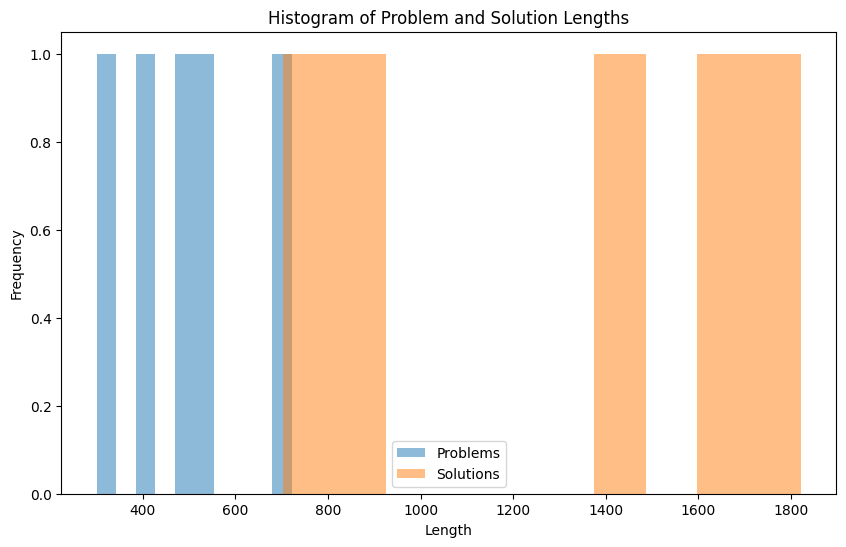

In [ ]:
make_distribution_length_plot(responses)

In [ ]:
df_1M['problem'][4]

'One of the most significant problems facing the environment today is the rampant use and disposal of plastics. These materials are not biodegradable and take hundreds of years to decompose, leading to significant pollution in our oceans and landfills. This problem is exacerbated by the fact that the production of new plastic is cheaper than recycling existing plastic, leading many companies to opt for the former.   '

In [ ]:
df_1M['problem'][0]

'The alarming rise of electronic waste (e-waste) due to the constant upgrading and purchasing of new electronic devices is contributing to a major environmental problem. It not only puts a strain on the limited resources available for manufacture of these electronic products but also results to harmful waste which ends up in landfills, improperly disposed and causing environmental degradation.  '

# LEVEL 2M: n instances with persona

In [ ]:
default_context_level2M = """ We are excited to announce an opportunity for freelancers to collaborate with researchers at the Digital, Data, and Design Institute at Harvard to source the most innovative and cutting-edge circular economy solutions for the business world.

Circular Economy is a simple idea.

Basically it involves sharing, leasing, reusing, repairing, refurbishing and recycling existing materials and products as long as possible.

We would like you to submit your circular economy idea, which can be a unique new idea or an existent idea that is used in the industry.

Here is an example: Car Sharing in order to reduce the carbon footprint associated with driving.

Submit your real-life use cases on how companies can implement the circular economy in their businesses. New ideas are also welcome, even if they are 'moonshots'. Your suggestions will help Harvard researchers understand the impact of the circular economy on business. Let's get creative and revolutionize the world through the circular economy!

Your goal is to win the top monetary prizes by satisfying to the maximum the following evaluation criteria.
* Novelty (How different is it from existing solutions?)
* Environmental Impact (How much does it benefit the planet?)
* Financial Impact (What financial value can it create for businesses?)
* Feasibility and Scalability of Implementation (How likely is it to succeed and how scalable is it?)

To answer the question, you will take the perspective of the following persona:
"""


prompt_level2M = """Answer the following two questions to propose a circular economy idea that could win the challenge according to the evaluation criteria.

Problem: Tell us about the problem your solution is meant to solve.

Solution: Describe the solution in your own words.

Use the following template to answer:
Problem: <Write a high quality, concise1 answer, corresponding to the personality, inspiration, and knowledge of your persona.>
Solution: <Write a high quality, concise2 solution, corresponding to the personality, inspiration, and knowledge of your persona.>
"""

In [ ]:
# Assuming your original DataFrame is called 'df'

# Create a new DataFrame with the sentence column
new_df = df.copy()
new_df["sentence"] = ""

# Iterate over each row and generate the sentence
for index, row in new_df.iterrows():
    sentence = ""

    if not pd.isna(row["New.Job.Title"]):
        sentence += f"You are a {row['New.Job.Title']},"

    if not pd.isna(row["continent"]):
        if sentence:
            sentence += " located in"
        sentence += f" {row['continent']}."

    if not pd.isna(row["New.Industry.of.Solution"]):
        if sentence:
            sentence += " You propose a solution that applies to"
        sentence += f" {row['New.Industry.of.Solution']}."

    if not pd.isna(row["What.is.the.maturity.of.the.solution."]):
        if sentence:
            sentence += " The maturity of your solution is"
        sentence += f" {row['What.is.the.maturity.of.the.solution.']}."

    new_df.at[index, "sentence"] = sentence

In [ ]:
def generate_responses_level2M(df, prompt, column_name, default_context, adjectives_problem, adjectives_solution):
    responses = []
    adjectives_problem_list, adjectives_solution_list = [], []

    # List to store the generation times
    generation_times = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):

        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]

        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)

        # replace "concise" with the randomly selected adjective in the default context
        new_prompt = prompt.replace("concise1", adj1)
        new_prompt = new_prompt.replace("concise2", adj2)

        content = default_context + row["sentence"]

        # Start the timer
        start_time = time.time()

        try:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": content},
                    {"role": "user", "content": new_prompt}
                ])
            responses.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Error on row {i}: {e}")
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": content},
                    {"role": "user", "content": new_prompt}
                ])
            responses.append(response.choices[0].message.content)

        # Stop the timer and store the generation time
        end_time = time.time()
        generation_times.append(end_time - start_time)

    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    return pd.Series(responses), pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)


In [ ]:
n = 2 #TODO Change to 100
level2M, p_list, s_list = generate_responses_level2M(new_df[:n], prompt_level2M, 'LEVEL_2M',  default_context_level2M, adjectives_problem, adjectives_solution)
df_2M = create_df_answers(level2M, p_list, s_list, persona = new_df["sentence"][:n], level_name = "Level2M")

100%|██████████| 2/2 [01:12<00:00, 36.34s/it]

Min Generation Time: 34.093013763427734 seconds
Max Generation Time: 38.583587408065796 seconds
Average Generation Time: 36.338300585746765 seconds
Standard Deviation of Generation Time: 2.2452868223190308 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

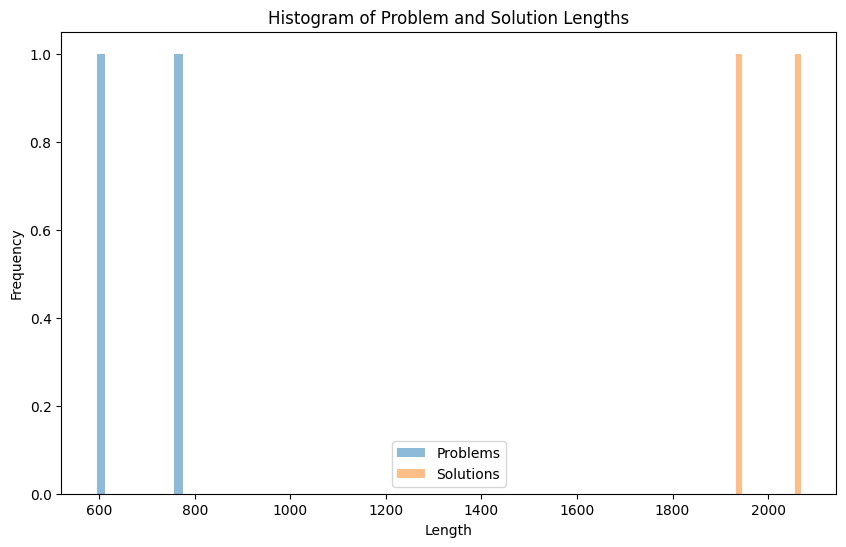

In [ ]:
make_distribution_length_plot(level2M)

In [ ]:
df_2M

,level,problem,solution,problem_adjective,solution_adjective,persona
0,Level2M,"In developing countries, particularly in Afric...","My solution is the set-up of a decentralized, ...",concise,long,"You are a Executives, Managers, and Entreprene..."
1,Level2M,"In Africa, both urban and rural areas are faci...","To address these problems, I propose an innova...",highly detailed and elaborate,highly detailed and elaborate,"You are a Executives, Managers, and Entreprene..."


# Level 3M: n instances with expert persona

In [ ]:
experts_list_23fields_5experts = [
    ("Stella McCartney", "Apparel & Textiles"),
    ("Eileen Fisher", "Apparel & Textiles"),
    ("Yvon Chouinard", "Apparel & Textiles"),
    ("Carry Somers", "Apparel & Textiles"),
    ("Orsola de Castro", "Apparel & Textiles"),

    ("Elon Musk", "Automobiles & Tires"),
    ("Carlos Tavares", "Automobiles & Tires"),
    ("Akio Toyoda", "Automobiles & Tires"),
    ("Mary Barra", "Automobiles & Tires"),
    ("Mate Rimac", "Automobiles & Tires"),

    ("John Mackey", "Beverages"),
    ("Denise Morrison", "Beverages"),
    ("Emmanuel Faber", "Beverages"),
    ("Howard Schultz", "Beverages"),
    ("James Quincey", "Beverages"),

    ("Dave Lennard", "Building Products"),
    ("William McDonough", "Building Products"),
    ("Thomas Rau", "Building Products"),
    ("Andy Karsner", "Building Products"),
    ("Michael Green", "Building Products"),

    ("Rick Fedrizzi", "Buildings"),
    ("Barry Giles", "Buildings"),
    ("Edward Mazria", "Buildings"),
    ("James Timberlake", "Buildings"),
    ("Stephen Kieran", "Buildings"),

    ("Scott Wine", "Construction Machinery"),
    ("Max Guinn", "Construction Machinery"),
    ("Raoul Jacquand", "Construction Machinery"),
    ("Martin Weissburg", "Construction Machinery"),
    ("Tom Linebarger", "Construction Machinery"),

    ("Andrew Liveris", "Construction Materials"),
    ("Bertrand Collomb", "Construction Materials"),
    ("John Elkington", "Construction Materials"),
    ("Bill Browning", "Construction Materials"),
    ("Jan Jenisch", "Construction Materials"),

    ("Tim Cook", "Consumer Electronics"),
    ("Ren Zhengfei", "Consumer Electronics"),
    ("Satya Nadella", "Consumer Electronics"),
    ("Jensen Huang", "Consumer Electronics"),
    ("Kenichiro Yoshida", "Consumer Electronics"),

    ("Anthony Pratt", "Containers & Packaging"),
    ("Mark Vergnano", "Containers & Packaging"),
    ("Stefan De Loecker", "Containers & Packaging"),
    ("John Hayes", "Containers & Packaging"),
    ("Ramon Laguarta", "Containers & Packaging"),

    ("Fabrizio Freda", "Cosmetics"),
    ("Jean-Paul Agon", "Cosmetics"),
    ("David Greenberg", "Cosmetics"),
    ("Sue Y. Nabi", "Cosmetics"),
    ("Alex Keith", "Cosmetics"),

    ("Hubertus Muehlhaeuser", "Electrical Equipment"),
    ("Simon Segars", "Electrical Equipment"),
    ("Uday Yadav", "Electrical Equipment"),
    ("Joe Hogan", "Electrical Equipment"),
    ("Eric Rondolat", "Electrical Equipment"),

    ("Larry Fink", "Financials"),
    ("Catherine Howarth", "Financials"),
    ("Anne Finucane", "Financials"),
    ("David Blood", "Financials"),
    ("Ray Dalio", "Financials"),

    ("John Mackey", "Food"),
    ("Denise Morrison", "Food"),
    ("Emmanuel Faber", "Food"),
    ("Howard Schultz", "Food"),
    ("James Quincey", "Food"),

    ("Anders Thomas", "Forest Products"),
    ("Berry Wiersum", "Forest Products"),
    ("Luke A. Finlay III", "Forest Products"),
    ("Paul Polman", "Forest Products"),
    ("William L. Kovacs", "Forest Products"),

    ("Alex Gorsky", "Health Care Products"),
    ("Stefan De Loecker", "Health Care Products"),
    ("Emma Walmsley", "Health Care Products"),
    ("Leif Johansson", "Health Care Products"),
    ("Severin Schwan", "Health Care Products"),

    ("Andrew Martin", "Home Furnishings"),
    ("Patricia Urquiola", "Home Furnishings"),
    ("Thomas Rau", "Home Furnishings"),
    ("Marcus Engman", "Home Furnishings"),
    ("Mette Hay", "Home Furnishings"),

    ("Mark Bitzer", "Household Appliances"),
    ("Pat Bassett", "Household Appliances"),
    ("William L. McComb", "Household Appliances"),
    ("Kevin Nolan", "Household Appliances"),
    ("Uwe Raschke", "Household Appliances"),

    ("Darius Adamczyk", "Industrial Machinery"),
    ("Scott Wine", "Industrial Machinery"),
    ("Greg Hayes", "Industrial Machinery"),
    ("Nick Blazquez", "Industrial Machinery"),
    ("Jeff Immelt", "Industrial Machinery"),

    ("Oleg Deripaska", "Metals: Beyond Big 4"),
    ("Richard Adkerson", "Metals: Beyond Big 4"),
    ("Ivan Glasenberg", "Metals: Beyond Big 4"),
    ("Mark Cutifani", "Metals: Beyond Big 4"),
    ("Mark Eames", "Metals: Beyond Big 4"),

    ("Sundar Pichai", "Software & IT Services"),
    ("Lisa P. Jackson", "Software & IT Services"),
    ("Satya Nadella", "Software & IT Services"),
    ("Marc Benioff", "Software & IT Services"),
    ("Arvind Krishna", "Software & IT Services"),

    ("Tim Cook", "Technology/ Hardware Products"),
    ("Lisa Su", "Technology/ Hardware Products"),
    ("Pat Gelsinger", "Technology/ Hardware Products"),
    ("Jensen Huang", "Technology/ Hardware Products"),
    ("Michael Dell", "Technology/ Hardware Products"),

    ("Frederick W. Smith", "Transportation & Logistics"),
    ("David Abney", "Transportation & Logistics"),
    ("Richard Anderson", "Transportation & Logistics"),
    ("James Foote", "Transportation & Logistics"),
    ("Lance Fritz", "Transportation & Logistics"),

    ("David Steiner", "Waste Management"),
    ("Patrick Dovigi", "Waste Management"),
    ("Ronald Mittelstaedt", "Waste Management"),
    ("Darren Gruendel", "Waste Management"),
    ("Richard Burke", "Waste Management")
]

random.shuffle(experts_list_23fields_5experts)
df_experts = pd.DataFrame(experts_list_23fields_5experts, columns=["persona", "field"])

In [ ]:
def generate_responses_level3M(df, prompt, column_name, default_context, adjectives_problem, adjectives_solution):
    responses = []
    adjectives_problem_list, adjectives_solution_list = [], []

    # List to store the generation times
    generation_times = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        sentence_persona = "You are "+ row["persona"] + " an expert in " + row["field"] +"."

        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]
        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)

        # replace "concise" with the randomly selected adjective in the default context
        new_prompt = prompt.replace("concise1", adj1)
        new_prompt = new_prompt.replace("concise2", adj2)

        content = default_context + sentence_persona

        # Start the timer


        try:
            start_time = time.time()
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": content},
                    {"role": "user", "content": new_prompt}
                ])
            # Stop the timer and store the generation time
            end_time = time.time()
            generation_times.append(end_time - start_time)
            responses.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Error on row {i}: {e}")
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": content},
                    {"role": "user", "content": new_prompt}
                ])
            responses.append(response.choices[0].message.content)



    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    return pd.Series(responses), pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)


In [ ]:
# TODO Change n
n = 2
level3M, p_list, s_list = generate_responses_level3M(df_experts[:n], prompt_level2M, 'LEVEL3M', default_context_level2M, adjectives_problem, adjectives_solution)
df_3M = create_df_answers(level3M, p_list, s_list, persona = df_experts["persona"][:n], level_name = "Level3M")

100%|██████████| 2/2 [01:08<00:00, 34.06s/it]

Min Generation Time: 29.847463130950928 seconds
Max Generation Time: 38.2646369934082 seconds
Average Generation Time: 34.056050062179565 seconds
Standard Deviation of Generation Time: 4.208586931228638 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

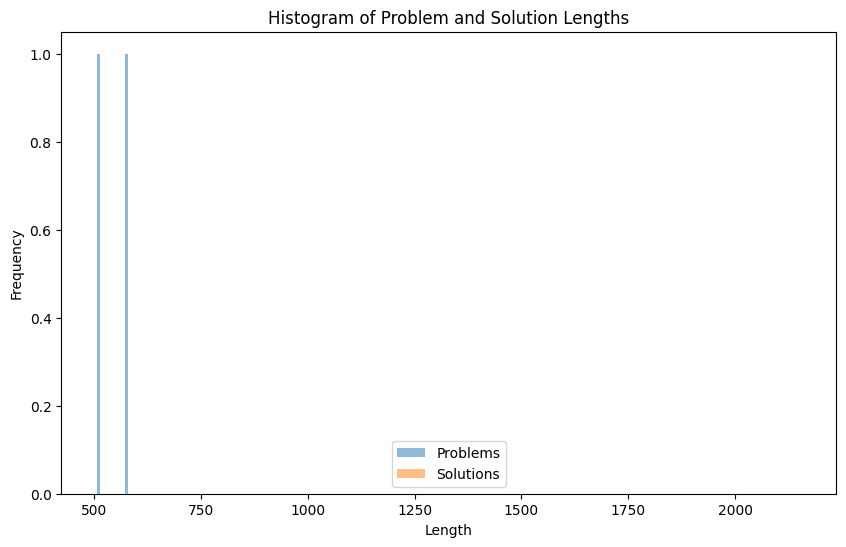

In [ ]:
make_distribution_length_plot(level3M)

In [ ]:
df_3M

,level,problem,solution,problem_adjective,solution_adjective,persona
0,Level3M,Rapid advancements in technology tend to resul...,My solution to reduce electronic waste and pro...,concise,long,Sundar Pichai
1,Level3M,"In the industrial machinery sector, a signifi...",NaN,highly detailed and elaborate,highly detailed and elaborate,Greg Hayes


# LEVEL 1S: 1 instance but no persona

In [ ]:
default_context_level1S = """ We are excited to announce an opportunity for freelancers to collaborate with researchers at the Digital, Data, and Design Institute at Harvard to source the most innovative and cutting-edge circular economy solutions for the business world.

Circular Economy is a simple idea.

Basically it involves sharing, leasing, reusing, repairing, refurbishing and recycling existing materials and products as long as possible.

We would like you to submit your circular economy idea, which can be a unique new idea or an existent idea that is used in the industry.

Here is an example: Car Sharing in order to reduce the carbon footprint associated with driving.

Submit your real-life use cases on how companies can implement the circular economy in their businesses. New ideas are also welcome, even if they are 'moonshots'. Your suggestions will help Harvard researchers understand the impact of the circular economy on business. Let's get creative and revolutionize the world through the circular economy!

Your goal is to win the top monetary prizes by satisfying to the maximum the following evaluation criteria.
* Novelty (How different is it from existing solutions?)
* Environmental Impact (How much does it benefit the planet?)
* Financial Impact (What financial value can it create for businesses?)
* Feasibility and Scalability of Implementation (How likely is it to succeed and how scalable is it?)

Answer the following two questions to propose a circular economy idea that could win the challenge according to the evaluation criteria.

Problem: Tell us about the problem your solution is meant to solve.

Solution: Describe the solution in your own words.

Use the following template to answer:
Problem: <Write a high quality answer.>
Solution: <Write a high quality solution.>

We will ask to answer these questions several times, and make sure each new answer tackles a different problem than the previous ones and proposes a different solution."""


In [ ]:
import random
import time
from tqdm import tqdm
import pandas as pd
import openai

def estimate_token_count(message):
    """
    Rough estimation of token count. Real token count could be different.
    """
    return len(message.split())

def generate_responses_level1S(df, column_name, default_context, adjectives_problem, adjectives_solution):
    responses = []
    generation_times = []
    adjectives_problem_list, adjectives_solution_list = [], []

    total_tokens = estimate_token_count(default_context)
    messages = [{"role": "system", "content": default_context}]

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        content = "Give a new high quality, concise1 Problem and high quality, concise2 Solution. Make sure to tackle a different problem than the previous ones and propose a different solution. Make also sure your answers satisfy the evaluation criteria (novelty, environmental impact, financial impact, feasibility and scalability)."

        # select a random adjective from the provided list
        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]
        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)
        # replace "concise" with the randomly selected adjective in the default context
        content = content.replace("concise1", adj1)
        content = content.replace("concise2", adj2)
        tokens_in_content = estimate_token_count(content)

        if total_tokens + tokens_in_content > 7000:
            if len(messages) > 2:
                # Remove the 2nd and 3rd message
                removed_message_2 = messages.pop(1)  # Remove second message
                total_tokens -= estimate_token_count(removed_message_2["content"])
                if len(messages) > 1:
                    removed_message_3 = messages.pop(1)  # Remove third message (which is now at the second position after the previous pop)
                    total_tokens -= estimate_token_count(removed_message_3["content"])

        try:
            messages.append({"role": "user", "content": content})
            total_tokens += tokens_in_content
            start_time = time.time()
            response = client.chat.completions.create(
                model="gpt-4",
                messages=messages
            )
            # Stop the timer and store the generation time
            end_time = time.time()
            generation_times.append(end_time - start_time)

            model_response = response.choices[0].message.content
            total_tokens += estimate_token_count(model_response)
            messages.pop()
            responses.append(model_response)
            messages.append({"role": "system", "content": model_response})
        except openai.error.RateLimitError as e:
            print(f"Rate limit error, sleeping for 10 seconds. Error details: {e}")
            time.sleep(20)
            continue  # Skip the rest of this iteration and go to the next one
        except Exception as e:
            print(f"Error on row {i}: {e}")

    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    return pd.Series(responses), messages, pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)


In [ ]:
# TODO CHANGE TO 100 AND HANDLE PROBLEM
n = 1
level1S, m, p_list, s_list = generate_responses_level1S(new_df[:n], 'LEVEL1S', default_context_level1S, adjectives_problem, adjectives_solution)
df_1S = create_df_answers(level1S, p_list, s_list, persona = None, level_name = "Level1S")

100%|██████████| 1/1 [00:34<00:00, 34.67s/it]

Min Generation Time: 34.66301488876343 seconds
Max Generation Time: 34.66301488876343 seconds
Average Generation Time: 34.66301488876343 seconds
Standard Deviation of Generation Time: 0.0 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_1S

,level,problem,solution,problem_adjective,solution_adjective,persona
0,Level1S,The fast fashion industry is notorious for not...,"A hybrid concept of ""Fashion-as-a-Service"" (Fa...",concise,long,NaN


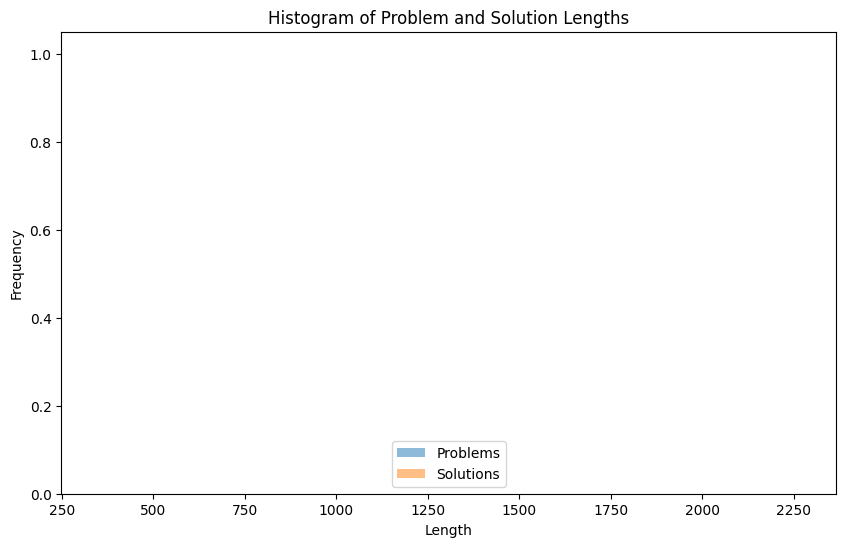

In [ ]:
make_distribution_length_plot(level1S)

# LEVEL 2S: 1 instance, prompt includes personas

In [ ]:
default_context_level2S = """
We are excited to announce an opportunity for freelancers to collaborate with researchers at the Digital, Data, and Design Institute at Harvard to source the most innovative and cutting-edge circular economy solutions for the business world.

Circular Economy is a simple idea.

Basically it involves sharing, leasing, reusing, repairing, refurbishing and recycling existing materials and products as long as possible.

We would like you to submit your circular economy idea, which can be a unique new idea or an existent idea that is used in the industry.

Here is an example: Car Sharing in order to reduce the carbon footprint associated with driving.

Submit your real-life use cases on how companies can implement the circular economy in their businesses. New ideas are also welcome, even if they are 'moonshots'. Your suggestions will help Harvard researchers understand the impact of the circular economy on business. Let's get creative and revolutionize the world through the circular economy!

Your goal is to win the top monetary prizes by satisfying to the maximum the following evaluation criteria.
* Novelty (How different is it from existing solutions?)
* Environmental Impact (How much does it benefit the planet?)
* Financial Impact (What financial value can it create for businesses?)
* Feasibility and Scalability of Implementation (How likely is it to succeed and how scalable is it?)

Answer the following two questions to propose a circular economy idea that could win the challenge according to the evaluation criteria.

Problem: Tell us about the problem your solution is meant to solve.

Solution: Describe the solution in your own words.

Answer following this template:
Problem: <Write a high quality answer, corresponding to the personality, inspiration, and knowledge of your persona.>
Solution: <Write a high quality solution, corresponding to the personality, inspiration, and knowledge of your persona.>

We will give you a series of different personas, and make sure each new answer from each persona tackles a different problem than the previous ones and proposes a different solution. Make sure each answer to correspond to the perspective, characteristics, and knowledge of your persona.
"""

In [ ]:
def generate_responses_level2S(df, column_name, default_context, adjectives_problem, adjectives_solution):
    responses = []
    adjectives_problem_list, adjectives_solution_list = [], []

    # List to store the generation times
    generation_times = []

    total_tokens = estimate_token_count(default_context)
    messages = [{"role": "system", "content": default_context}]

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        content = "Give a new high quality, concise1 Problem and high quality, concise2 Solution. Make sure to tackle a different problem than the previous ones and propose a different solution. Make also sure your answers satisfy the evaluation criteria (novelty, environmental impact, financial impact, feasibility and scalability). The persona you embody for this answer:"
        content = content + row["sentence"]
        # select a random adjective from the provided list
        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]
        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)
        # replace "concise" with the randomly selected adjective in the default context
        content = content.replace("concise1", adj1)
        content = content.replace("concise2", adj2)
        tokens_in_content = estimate_token_count(content)

        if total_tokens + tokens_in_content > 7000:
            if len(messages) > 2:
                # Remove the 2nd and 3rd message
                removed_message_2 = messages.pop(1)  # Remove second message
                total_tokens -= estimate_token_count(removed_message_2["content"])
                if len(messages) > 1:
                    removed_message_3 = messages.pop(1)  # Remove third message (which is now at the second position after the previous pop)
                    total_tokens -= estimate_token_count(removed_message_3["content"])

        try:
            messages.append({"role": "user", "content": content})
            total_tokens += tokens_in_content

            # Start the timer
            start_time = time.time()

            response = client.chat.completions.create(
                model="gpt-4",
                messages=messages
            )

            # Stop the timer and store the generation time
            end_time = time.time()
            generation_times.append(end_time - start_time)

            model_response = response.choices[0].message.content
            total_tokens += estimate_token_count(model_response)
            messages.pop()
            responses.append(model_response)
            messages.append({"role": "system", "content": model_response})

        except openai.error.RateLimitError as e:
            print(f"Rate limit error, sleeping for 10 seconds. Error details: {e}")
            time.sleep(20)
            continue  # Skip the rest of this iteration and go to the next one
        except Exception as e:
            print(f"Error on row {i}: {e}")

    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    return pd.Series(responses), messages, pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)


In [ ]:
# TODO Change n to 125
n = 2

level_2S, m, p_list, s_list = generate_responses_level2S(new_df[:n], 'LEVEL2S', default_context_level2S, adjectives_problem, adjectives_solution)
df_2S = create_df_answers(level_2S, p_list, s_list, persona = new_df["sentence"][:n], level_name = "Level2S")

100%|██████████| 2/2 [01:14<00:00, 37.17s/it]

Min Generation Time: 35.610312938690186 seconds
Max Generation Time: 38.721471548080444 seconds
Average Generation Time: 37.165892243385315 seconds
Standard Deviation of Generation Time: 1.5555793046951294 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

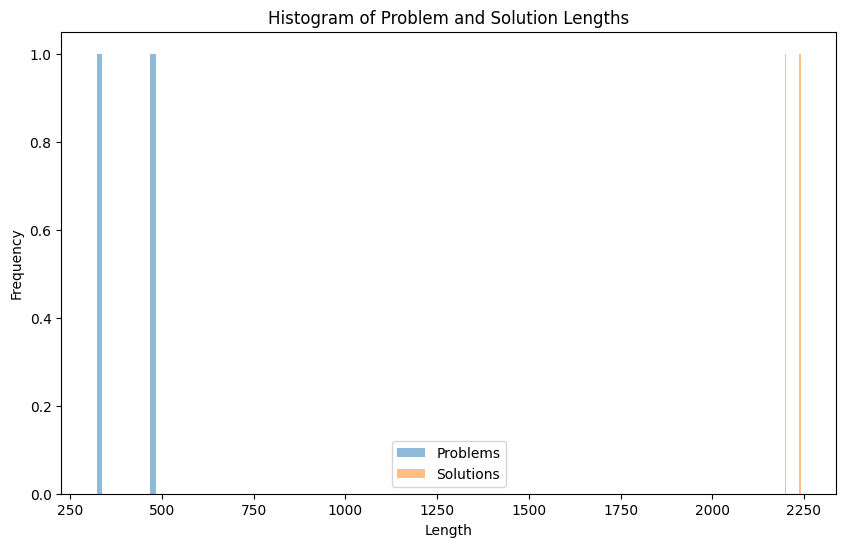

In [ ]:
make_distribution_length_plot(level_2S)

# LEVEL 3S: 1 instance, personas are real-world experts

In [ ]:
def generate_responses_level3S(df, column_name, default_context, adjectives_problem, adjectives_solution):
    responses = []
    adjectives_problem_list, adjectives_solution_list = [], []
    # List to store the generation times
    generation_times = []

    total_tokens = estimate_token_count(default_context)
    messages = [{"role": "system", "content": default_context}]

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        content = "Give a new high quality, concise1 Problem and high quality, concise2 Solution. Make sure to tackle a different problem than the previous ones and propose a different solution. Make also sure your answers satisfy the evaluation criteria (novelty, environmental impact, financial impact, feasibility and scalability). The persona you embody for this answer: "
        content = content + row["persona"]+" who has expertise in "+row["field"] + "."
        # select a random adjective from the provided list
        adj1 = adjectives_problem[i]
        adj2 = adjectives_solution[i]

        adjectives_problem_list.append(adj1)
        adjectives_solution_list.append(adj2)
        # replace "concise" with the randomly selected adjective in the default context
        content = content.replace("concise1", adj1)
        content = content.replace("concise2", adj2)
        tokens_in_content = estimate_token_count(content)

        if total_tokens + tokens_in_content > 7000:
            if len(messages) > 2:
                # Remove the 2nd and 3rd message
                removed_message_2 = messages.pop(1)  # Remove second message
                total_tokens -= estimate_token_count(removed_message_2["content"])
                if len(messages) > 1:
                    removed_message_3 = messages.pop(1)  # Remove third message (which is now at the second position after the previous pop)
                    total_tokens -= estimate_token_count(removed_message_3["content"])

        try:
            messages.append({"role": "user", "content": content})
            total_tokens += tokens_in_content
            start_time = time.time()
            response = client.chat.completions.create(
                model="gpt-4",
                messages=messages
            )
            # Stop the timer and store the generation time
            end_time = time.time()
            generation_times.append(end_time - start_time)
            model_response = response.choices[0].message.content
            total_tokens += estimate_token_count(model_response)
            messages.pop()
            responses.append(model_response)
            messages.append({"role": "system", "content": model_response})
        except Exception as e:
            print(f"Rate limit error, sleeping for 10 seconds. Error details: {e}")
            time.sleep(20)
            continue  # Skip the rest of this iteration and go to the next one

    # Compute the required statistics
    min_time = np.min(generation_times)
    max_time = np.max(generation_times)
    avg_time = np.mean(generation_times)
    std_time = np.std(generation_times)

    print(f"Min Generation Time: {min_time} seconds")
    print(f"Max Generation Time: {max_time} seconds")
    print(f"Average Generation Time: {avg_time} seconds")
    print(f"Standard Deviation of Generation Time: {std_time} seconds")

    return pd.Series(responses), messages, pd.Series(adjectives_problem_list), pd.Series(adjectives_solution_list)


In [ ]:
# TODO change n
n = 3

level3S, m, p_list, s_list = generate_responses_level3S(df_experts[:n], 'LEVEL3S', default_context_level2S, adjectives_problem, adjectives_solution)
df_3S = create_df_answers(level3S, p_list, s_list, persona = df_experts["persona"][:n], level_name = "Level3S")

100%|██████████| 3/3 [01:36<00:00, 32.11s/it]

Min Generation Time: 25.628016471862793 seconds
Max Generation Time: 35.553098917007446 seconds
Average Generation Time: 32.10285631815592 seconds
Standard Deviation of Generation Time: 4.581699594957688 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

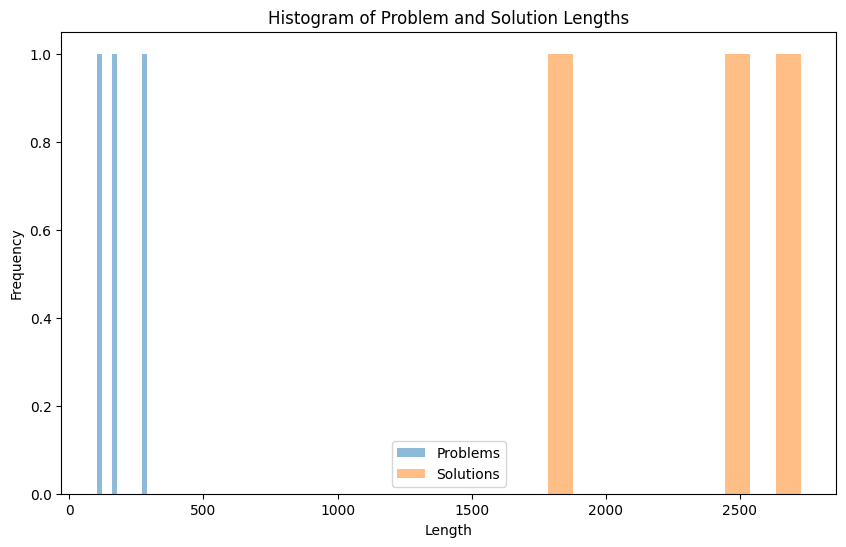

In [ ]:
make_distribution_length_plot(level3S)

In [ ]:
df_3S

,level,problem,solution,problem_adjective,solution_adjective,persona
0,Level3S,The rapid growth of the IT industry has produc...,"As the CEO of Google, I am privy to the proble...",concise,long,Sundar Pichai
1,Level3S,The industrial machining sector creates an eno...,As the CEO of United Technologies and someone ...,highly detailed and elaborate,highly detailed and elaborate,Greg Hayes
2,Level3S,The global packaging industry contributes sign...,As the CEO of Chemours and an expert in chemic...,20-sentence,brief,Mark Vergnano
